In [1]:
import os
import scipy.io
from sepia.SepiaModelSetup import setup_model
from sepia.SepiaData import SepiaData as SepiaData
import numpy as np
import sepia.SepiaPlot as SepiaPlot
import matplotlib.pyplot as plt

mat_fn = 'neddTemp.mat'
if os.path.isfile(mat_fn):
    print('Found matfile, loading from multi_sim_and_obs_mcmc_test.mat \n')
    matfile = scipy.io.loadmat(mat_fn) # dictionary
    
design = np.array([
    [0.7714,    0.4286,    0.0286],
    [0.3714,    0.1143,    0.7143],
    [0.1714,    0.4571,    0.8857],
    [0.3429,    0.6000,    0.8000],
    [0.8000,    0.6286,    0.4000],
    [0.7429,    0.5429,         0],
    [0.6571,    1.0000,    0.6286],
    [0.2857,         0,    0.4571],
    [0.5143,    0.9429,    0.2286],
    [0.6857,    0.3143,    0.6571],
    [0.8286,    0.2000,    1.0000],
    [0.9714,    0.3429,    0.6000],
    [0.4000,    0.8000,    0.2000],
    [0.5429,    0.2857,    0.2857],
    [0.9143,    0.8857,    0.2571],
    [0.0571,    0.0286,    0.0857],
    [0.1143,    0.5714,    0.7429],
    [0.2000,    0.2286,    0.3714],
    [0.4571,    0.9143,    0.3429],
    [0.6286,    0.7143,    0.6857],
    [     0,    0.8286,    0.9429],
    [0.8857,    0.0857,    0.9714],
    [0.2286,    0.0571,    0.5714],
    [0.7143,    0.1714,    0.8571],
    [0.2571,    0.4857,    0.1429],
    [0.5714,    0.4000,    0.8286],
    [0.9429,    0.6857,    0.4857],
    [0.4857,    0.1429,    0.1143],
    [1.0000,    0.8571,    0.9143],
    [0.6000,    0.6571,    0.5143],
    [0.1429,    0.7429,    0.5429],
    [0.8571,    0.2571,    0.0571],
    [0.3143,    0.3714,    0.4286],
    [0.4286,    0.7714,    0.7714],
    [0.0286,    0.9714,    0.3143],
    [0.0857,    0.5143,    0.1714]])

m = design.shape[0]


phi_dat = matfile['phidat']
time_dat_1 = matfile['timedat1']
time_dat_2 = matfile['timedat2']
time_dat_3 = matfile['timedat3']

time_phi_dat_1 = np.column_stack( ( np.concatenate((np.ones(phi_dat.shape[1])*time_dat_1[0],\
                                   np.ones(phi_dat.shape[1])*time_dat_1[1],\
                                       np.ones(phi_dat.shape[1])*time_dat_1[2])), np.tile(phi_dat,3).T ) )
time_phi_dat_2 = np.column_stack( ( (np.ones(phi_dat.shape[1])*time_dat_2).reshape(16,1), phi_dat.T ) )
time_phi_dat_3 = np.column_stack( ( np.concatenate((np.ones(phi_dat.shape[1])*time_dat_3[0],\
                                   np.ones(phi_dat.shape[1])*time_dat_3[1])), np.tile(phi_dat,2).T ) )
time_phi_dat = [time_phi_dat_1,time_phi_dat_2,time_phi_dat_3]
 
sim_time = matfile['time']
sim_phi  = matfile['phi']    
y_sim_ind_time_phi = np.zeros((22*26,2))
y_sim_ind_time_phi[:,0] = np.repeat(sim_time,26)
y_sim_ind_time_phi[:,1] = np.tile(sim_phi,22)
x_sim = matfile['Xlhs'][:,0].reshape(m,1)
y_sim = matfile['ye'].T
#t_sim = matfile['paramslhs']
t_sim = matfile['Xlhs'][:,1:3]


x_obs = matfile['xdat'].T # mass of HE by experiement

y_obs = [matfile['ydat1'].flatten('F'),matfile['ydat2'].flatten('F'),matfile['ydat3'].flatten('F')]
y_ind_obs = [time_phi_dat_1,time_phi_dat_2,time_phi_dat_3]
                    
data = SepiaData(x_sim = x_sim,t_sim = t_sim,y_sim = y_sim,y_ind_sim = y_sim_ind_time_phi,\
                 x_obs = x_obs, y_obs = y_obs,y_ind_obs = y_ind_obs)
data.transform_xt()

Found matfile, loading from multi_sim_and_obs_mcmc_test.mat 



In [2]:
#%% K basis

# sim
ysimmean = np.mean(y_sim,0)
ysimsd = np.std(y_sim)
ysimStd = (y_sim - np.tile(ysimmean,m).reshape(y_sim.shape))/ysimsd
data.sim_data.orig_y_mean = ysimmean
data.sim_data.orig_y_sd = ysimsd
data.sim_data.y_std = ysimStd
# now represent ye images using eof's
U, s, V = np.linalg.svd(ysimStd.T, full_matrices=False)
numPC = 3
data.sim_data.K = U[:,0:numPC]*s[0:numPC]/np.sqrt(m)
data.sim_data.K = data.sim_data.K.T

# obs
n = 3 # number of experiments
phi = matfile['phi']
time = matfile['time']
phimat = np.repeat(phi,time.shape[0]).reshape((time.shape[0],phi.shape[1]),order='F')
timemat = np.repeat(time,phi.shape[1]).reshape((time.shape[0],phi.shape[1]))
# compute simulator mean values simdat.ymean interpolated to the data values...
interp_func = scipy.interpolate.interp2d(phimat[0,:],timemat[:,0],data.sim_data.orig_y_mean.reshape((22,26),order='F'))
data.obs_data.orig_y_mean = []
for k in range(n):
    ymk = interp_func(np.unique(data.obs_data.y_ind[k][:,1]),np.unique(data.obs_data.y_ind[k][:,0]))                                                                             
    data.obs_data.orig_y_mean.append(ymk.flatten())
    
# now compute the centered, scaled observed arrival times yStd
data.obs_data.y_std = []
for k in range(n):
    data.obs_data.y_std.append((data.obs_data.y[k] - data.obs_data.orig_y_mean[k])/data.sim_data.orig_y_sd)

data.obs_data.K = []
for k in range(n):
    data.obs_data.K.append(np.zeros((data.obs_data.y_std[k].shape[0], numPC)))
    for j in range(numPC):
        f = scipy.interpolate.interp2d(phimat[0,:],timemat[:,0],np.reshape(data.sim_data.K[j,:],(22,26),order='F'))
        data.obs_data.K[k][:,j] = f(data.obs_data.y_ind[k][:,1],data.obs_data.y_ind[k][:,0])[:,0]

for k in range(n):
    data.obs_data.K[k] = data.obs_data.K[k].T

In [3]:
#%% D basis
def dist2pi(x1,x2):
    # computes the distance assuming periodicity: 2pi=0
    # x1 and x2 are vectors with common length and values
    # between 0 and 2pi
    d = abs(x1-x2)
    iwrap = d > np.pi
    d[iwrap] = 2*np.pi - d[iwrap]
    return(d)
def dnorm(x,mu,scale):  
    # normal density in 1-d. 
    # It is scaled so that the 1-d integral is 1
    # mu and scale are scalars, x is an array...
    out=np.zeros(len(x))
    u=abs(x-mu)/scale
    out = (1.0/(np.sqrt(2*np.pi)*scale)) * np.exp(-.5 * u**2)
    return(out)

# compute the basis functions for the discrepancy function.  Each data set
# will get a obsData(k).n x pdelta matrix of basis functions.  
phiknots = np.arange(0,2*np.pi-.1,2*np.pi/8)
pphiknots = len(phiknots)
#Ddelt = zeros([ndat1 pphiknots]);
Dsim  = np.zeros((phi.shape[1], pphiknots))
for k in range(pphiknots):
    #Ddelt(:,k) = dnorm(dist2pi(phidat,phiknots(k)*ones(size(phidat))),0,pi/8)';
    x = dist2pi(phi,phiknots[k]*np.ones(phi.shape[1])).flatten()
    Dsim[:,k] = dnorm(x=x,mu=0,scale=np.pi/8)


dknots = np.expand_dims(np.array([.04, -.03, .03, -.03, .02, -.03, .03, -.03]),1)*2.5
#datadelt = Ddelt*dknots;
#simdelt = Dsim*dknots

timeknots = np.linspace(0,.5,3)*1e-4
ptimeknots=len(timeknots)

data.obs_data.D = []
for k in range(n):
    knotlocstime = np.reshape(np.repeat(timeknots,pphiknots),(ptimeknots*pphiknots, 1))
    knotlocsphi = np.expand_dims(np.tile(phiknots,ptimeknots),1)
    pv = knotlocstime.shape[0]
    Dobs = np.zeros((data.obs_data.y_std[k].shape[0], pv))
    if k == 0: Dsim = np.zeros((data.sim_data.y_std.shape[1], pv))
    for j in range(pv):
        Dobs[:,j] = dnorm(time_phi_dat[k][:,0],knotlocstime[j],.25*1e-4)*\
            dnorm(dist2pi(time_phi_dat[k][:,1],knotlocsphi[j]*np.ones(time_phi_dat[k][:,1].shape[0])),0,np.pi/8)
        if k == 0:
            Dsim[:,j] = dnorm(timemat.flatten('F'),knotlocstime[j],.25*1e-4)*\
                dnorm(dist2pi(phimat.flatten('F'),knotlocsphi[j]*np.ones(len(phimat.flatten()))),0,np.pi/8)
    if k == 0: data.sim_data.D = Dsim
    data.obs_data.D.append(Dobs.T)
# now normalize Dobs and Dsim so that it gives a var=1 process
dmax = np.amax(np.amax(np.matmul(data.sim_data.D,data.sim_data.D.T)))
for k in range(n):
    data.obs_data.D[k] /= np.sqrt(dmax)
data.sim_data.D /= np.sqrt(dmax)

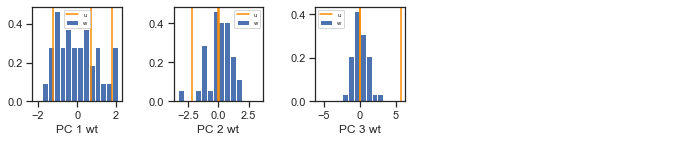

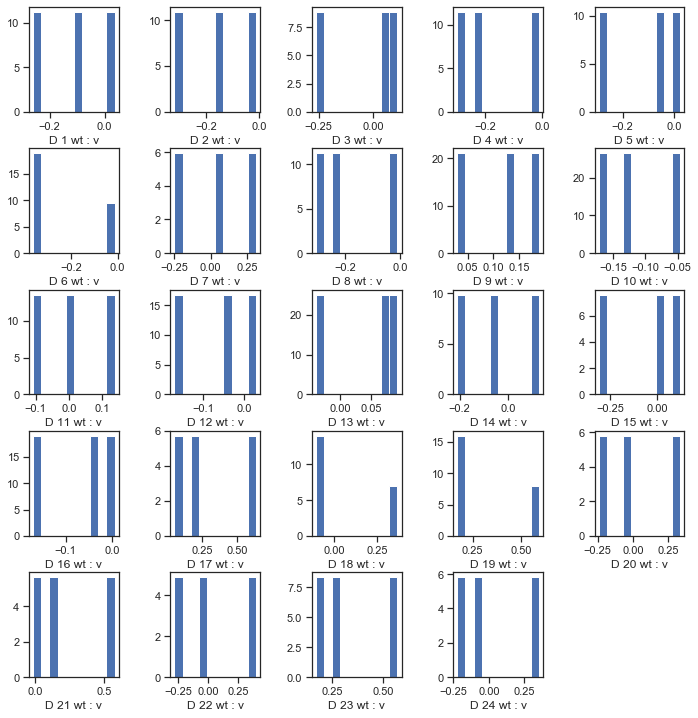

In [4]:
data.plot_K_weights()

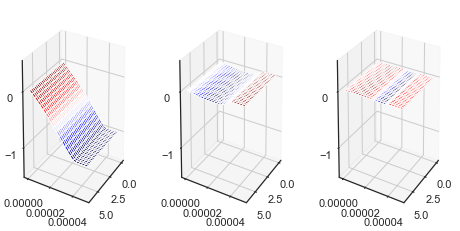

In [5]:
# plot K basis (simulation)
x,y = np.meshgrid(phi,time)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=plt.figaspect(0.5))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.plot_surface(x,y,data.sim_data.K[i,:].reshape((22,26),order='F'),cmap='seismic')
    ax.set_zlim([-1.5,.5])
    ax.view_init(20, 30)

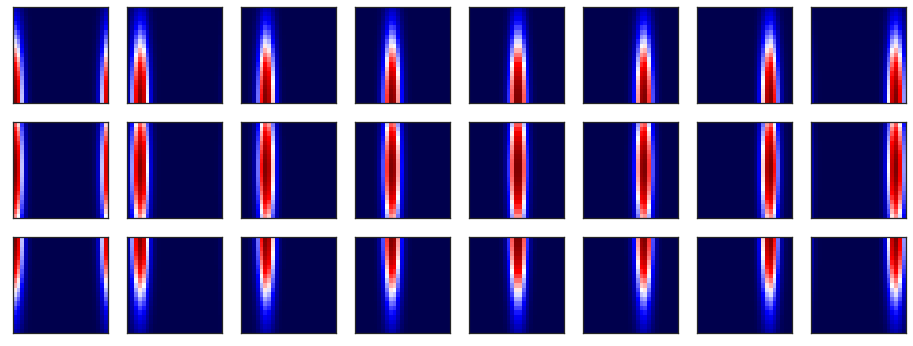

In [6]:
# plot D basis
fig, axs = plt.subplots(3,8,figsize=[16,6],sharex=True,sharey=True)
x,y = np.meshgrid(phi,time)
for i,ax in enumerate(axs.flatten()):
    ax.pcolormesh(x, y, data.sim_data.D[:,i].reshape((22,26),order='F'),cmap='seismic')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
plt.xlabel(r"angle \phi")
plt.ylabel("time")
plt.show()

Plotting up to 5 pairs. Change with parameter 'max_plots'


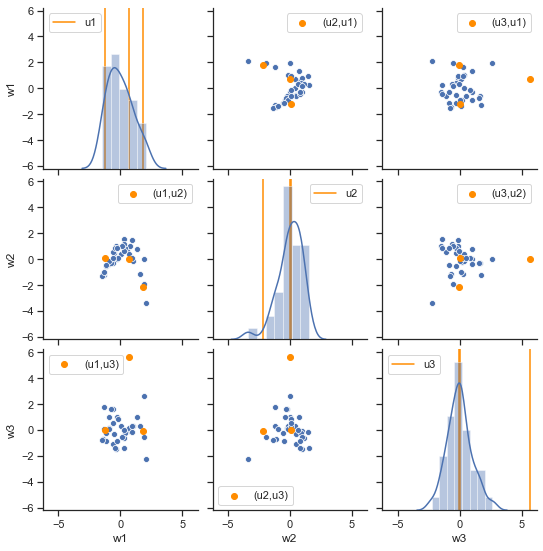

In [7]:
data.plot_u_w_pairs()

In [8]:
print(data)
model = setup_model(data)

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 572, obs y dimension ragged
n  =     3 (number of observed data)
m  =    36 (number of simulated data)
p  =     1 (number of inputs)
q  =     2 (number of additional simulation inputs to calibrate)
pu =     3 (transformed response dimension)
pv =    24 (transformed discrepancy dimension)



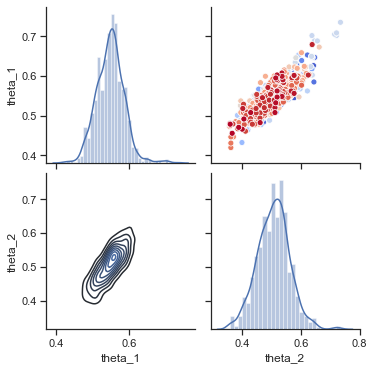

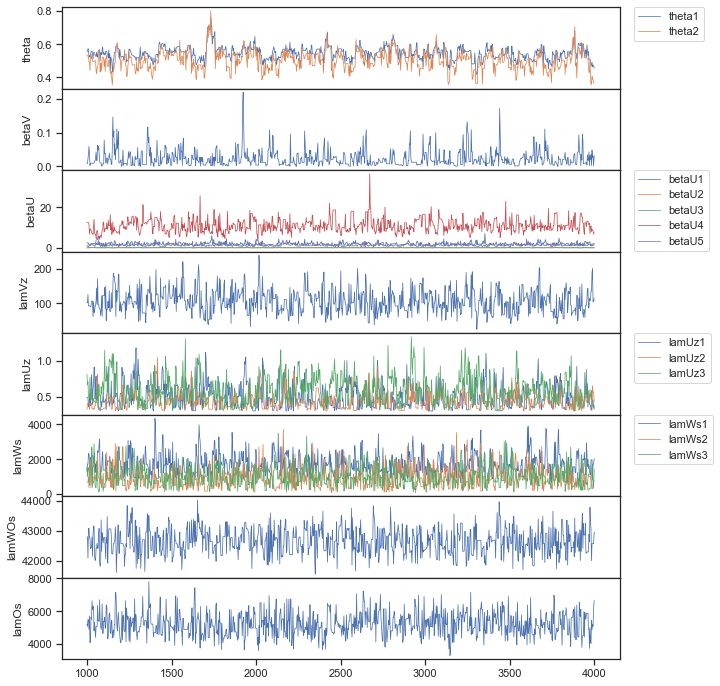

In [9]:
cachefile_name='neddermeyer.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name):
   model=pickle.load(open(cachefile_name, "rb" ))
else:
    model.tune_step_sizes(50, 20)
    model.do_mcmc(5000)
    pickle.dump(model, open( cachefile_name, "w+b" ))

samples_dict = {p.name: p.mcmc_to_array(trim=1000) for p in model.params.mcmcList}
SepiaPlot.theta_pairs(samples_dict)
SepiaPlot.mcmc_trace(samples_dict,start=1000,n_to_plot=1000,max_print=5)